In [1]:
import random as rd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import pandas as pd

## Tree Class

La classe Tree a pour but de modéliser l'arbre et le MDP

In [47]:
class Tree:
    
    def __init__(self,initSize,H,discount=1/1.05,valueUnitOfWood=10,costOfPlanting=-5
                 ,costOfMaintenance=-10,probaOfSick=1/16,probaOfGrowTwice=1/16,probaOfNotGrow=2/16):
        self.size=initSize
        self.initSize=initSize
        self.Hmax=H
        self.discount=discount
        self.valueUnitOfWood=valueUnitOfWood
        self.costOfPlanting=costOfPlanting
        self.costOfMaintenance=costOfMaintenance
        self.probaOfSick=probaOfSick
        self.probaOfGrowTwice=probaOfGrowTwice
        self.probaOfNotGrow=probaOfNotGrow
        self.probaOfGrowOne=1-(self.probaOfNotGrow+probaOfGrowTwice+probaOfSick)
    

    def get_all_rewards(self):
        R={}
        R[(-1,0)]=self.costOfMaintenance
        R[(-1,1)]=self.costOfPlanting
        for i in range(1,self.Hmax+1):
            R[(i,0)]=self.costOfMaintenance
            R[(i,1)]=i*self.valueUnitOfWood+self.costOfPlanting 
        return R

        
 
    def tree_sim(self,x,a,verbose=0):
        
        reward=0
        
        if a==1 or x==-1 : # si on coupe l'arbre et on en plante un autre de hauteur 1 ou alors que l'abre est malade
            # on gagne la taille*la valeur de chaque bout de bois - le coût de la plantation 
            # si l'abre n'est pas malade sinon on gagne juste rien
            if x==-1:
                reward=self.costOfPlanting
            else:
                reward=x*self.valueUnitOfWood+self.costOfPlanting 
            x=1
        
        else : # on coupe pas l'arbre
            choose=rd.random()

            # L'arbre tombe malade avec proba 1/16
            
            if choose<=(self.probaOfSick) :
                if verbose==1 :
                    print('The tree is falling sick')
                reward=self.costOfMaintenance
                x=-1
              
            # L'arbre grandit de 2 avec proba 1/16
            
            if choose>self.probaOfSick and choose<=(self.probaOfSick+self.probaOfGrowTwice) :
                if verbose==1 :
                    print('The tree grows of two units')
                
                if x<self.Hmax:
                    x=x+2
                
                reward=self.costOfMaintenance
             
            # L'arbre ne grandit pas avec proba 1/8
            
            if choose>(self.probaOfSick+self.probaOfGrowTwice) and choose<=(self.probaOfSick+self.probaOfGrowTwice+self.probaOfNotGrow):
                if verbose==1 :
                    print('The tree does not grow')
                    
                reward=self.costOfMaintenance

            # L'arbre grandit d'une unité avec proba 3/4
            
            if choose>(self.probaOfSick+self.probaOfGrowTwice+self.probaOfNotGrow) and choose<=1 :
                if verbose==1 :
                    print('The tree grows of one unit')
                
                if x<self.Hmax:
                    x=x+1
                
                reward=self.costOfMaintenance


        return reward,x
        
    def tree_MDP(self,actions,verbose=0):
        
        rewards=[]
        treeSizes=[]
        i=1
        
        if len(actions)==1:
            a=actions[0]
            sim=self.tree_sim(self.size,a,verbose)
            treeSizes=sim[1]
            rewards=sim[0]
            self.size=treeSizes
            
        if len(actions)>1:
            for a in actions:
                sim=self.tree_sim(self.size,a,verbose)
                x=sim[1]
                r=sim[0]*self.discount**(i) # Discounted reward
                self.size=x
                treeSizes.append(x)
                rewards.append(r)
                i=i+1
            
        return rewards,treeSizes
    

        
    def plot_MDP(self,rewards,treeSizes,cumul=True):
            

        plt.figure(figsize=(20,10))
        limit=np.zeros(len(treeSizes))-1
        plt.subplot(1,2,1)
        plt.plot(treeSizes,color='darkgreen',lw=3)
        plt.plot(limit,color='red',lw=1,alpha=0.8,linestyle='--')
        plt.xlim([-1,len(rewards)])
        #plt.ylim([0,max(treeSizes)+1])
        plt.title('Simulation of a growing tree', fontsize=15)
        plt.ylabel('Tree\'s Height', fontsize=10)
        plt.xlabel('time', fontsize=10)
        #plt.yticks(range(max(treeSizes)))
       
        plt.subplot(1,2,2)
        plt.plot(rewards,'r-')
        if cumul==True:
            plt.plot(np.cumsum(rewards),'b--',lw=2)
        plt.title('Rewards', fontsize=15)
        plt.ylabel('Value of rewards', fontsize=10)
        plt.xlabel('time', fontsize=10)
        #plt.yticks(range(min(np.cumsum(rewards)),max(rewards),3))
        plt.legend(['Reward at each time','Cumulative sum of rewards'])

        plt.show()
        
   
    

## Compute Matrix

La classe ComputeMatrix a pour but de créer les matrices suivantes et de faire des opérations dessus :

$$P1=
\begin{pmatrix}
   0 & 0 & \ldots & \ldots & \ldots & \ldots  & 0 \\
   1/16 & 2/16 & 12/16 & 1/16 & 0 & \ldots  & 0 \\
   1/16 & 0 & 2/16 & 12/16 & \ddots & \ldots & 0 \\
   1/16 & 0 & 0 & 2/16 & \ddots & \ddots  & 0 \\
   \vdots & \vdots & \vdots & 0 & \ddots & \ddots & 1/16\\
   \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & 12/16\\
   1/16 & 0 & 0 & 0 & 0 & 0 & 2/16\\
\end{pmatrix}$$



$$P2=
\begin{pmatrix}
   0 &1 & 0 & \ldots & 0  \\
   0 & 1 & 0 & \ldots & 0 \\
   \vdots & \vdots & \vdots & \ldots & \vdots \\
   0& 1 & 0 &\ldots & 0   
\end{pmatrix}$$

In [34]:
class ComputeMatrix:
 
    def tridiag(self,a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    
    def computePQ(self,H):
        a=np.zeros(H)+2/16
        b=np.zeros(H-1)+12/16
        c=np.zeros(H-2)+1/16
        e=np.zeros(H)+1/16
        e[0]=3/16
        P=self.tridiag(a, b, c,k1=0,k2=1,k3=2)
        P[:,0]=e
        Q=np.zeros((H,H))
        Q[:,0]=np.ones(H)
        return P,Q
        
    def inv(self,P,discount):
        I=np.eye(len(P))
        M1=(I-discount*P)
        Pinv=np.linalg.inv(M1)
        return Pinv           

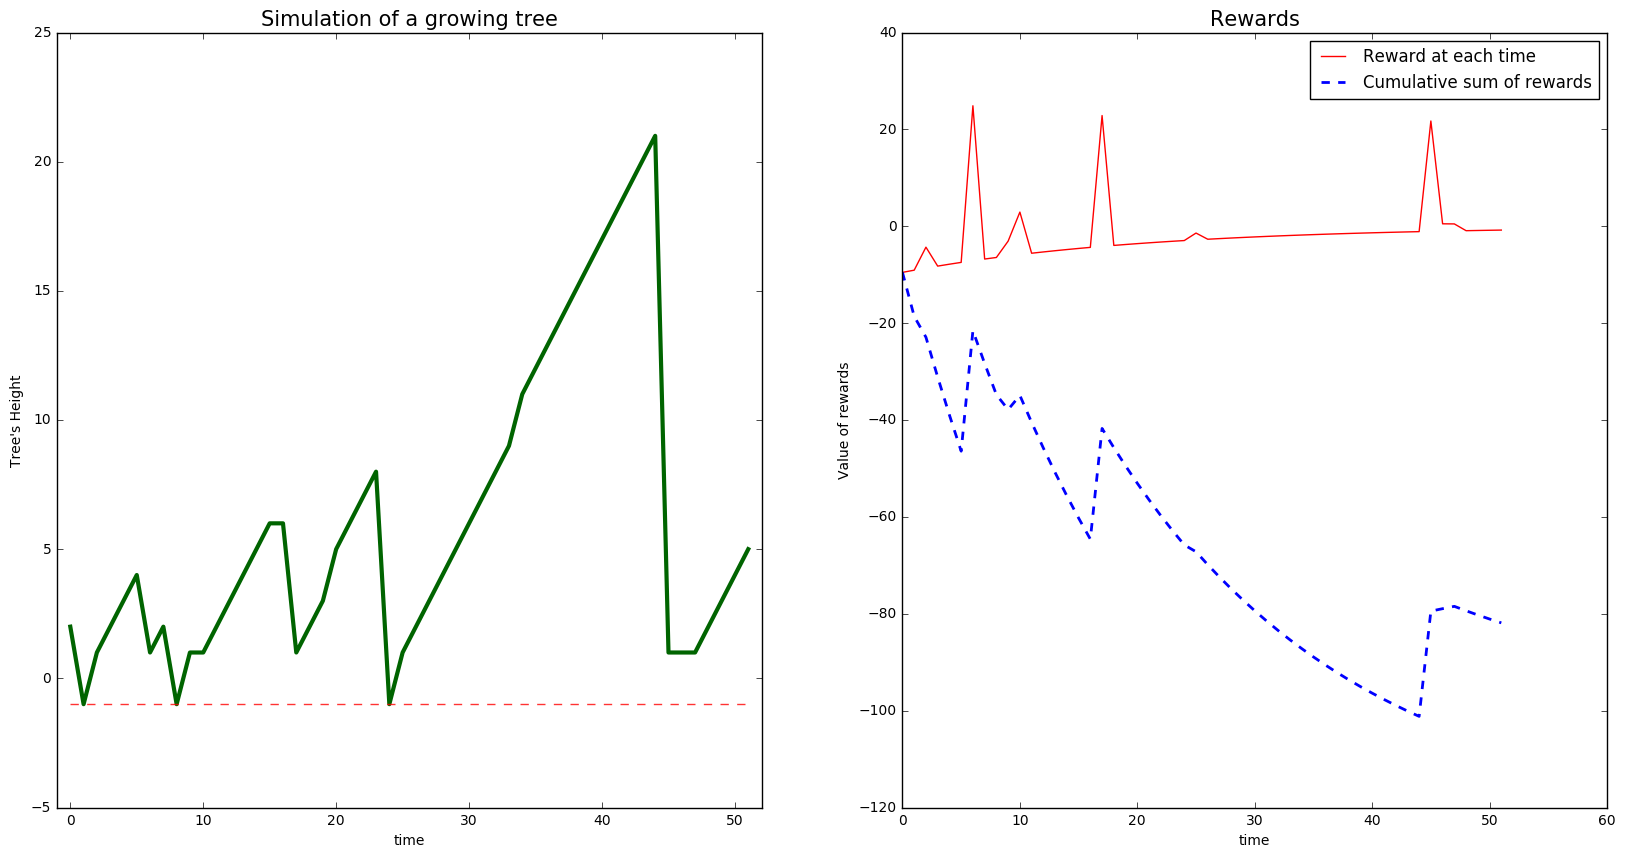

In [51]:
t=Tree(initSize=1,H=100)
actions=[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0]
rewards,treeSizes=t.tree_MDP(actions,verbose=0)
t.plot_MDP(rewards,treeSizes)

## Les Agents

Les agents définissent les policy à effectuer et les évaluent.

In [72]:
class Agent :
    
    def policy(self):
        raise NotImplementedError("Dumb ass ! Please implement this method") 
        
    def simul_policy(self,nIter,nbRuns,Tree):
        raise NotImplementedError("Dumb ass ! Please implement this method") 
        
    def ev_policy_direct_computation(self,tree):
        raise NotImplementedError("Dumb ass ! Please implement this method")
        
    def ev_policy_iterative_computation(self,tree):
        raise NotImplementedError("Dumb ass ! Please implement this method") 
        
    def ev_policy_motecarlo(self):
        raise NotImplementedError("Dumb ass ! Please implement this method") 
        
        


### Arbitrary Agent

In [78]:
class ArbitraryAgent(Agent,ComputeMatrix):
    
    def __init__(self,cut=10):
        Agent.__init__(self)
        ComputeMatrix.__init__(self)
        self.cut=cut
     
    # Doit implémenter une policy déterministe
    def policy(self,x):
        if x>=self.cut:
            return 1
        else:
            return 0
    

            

### Illustration

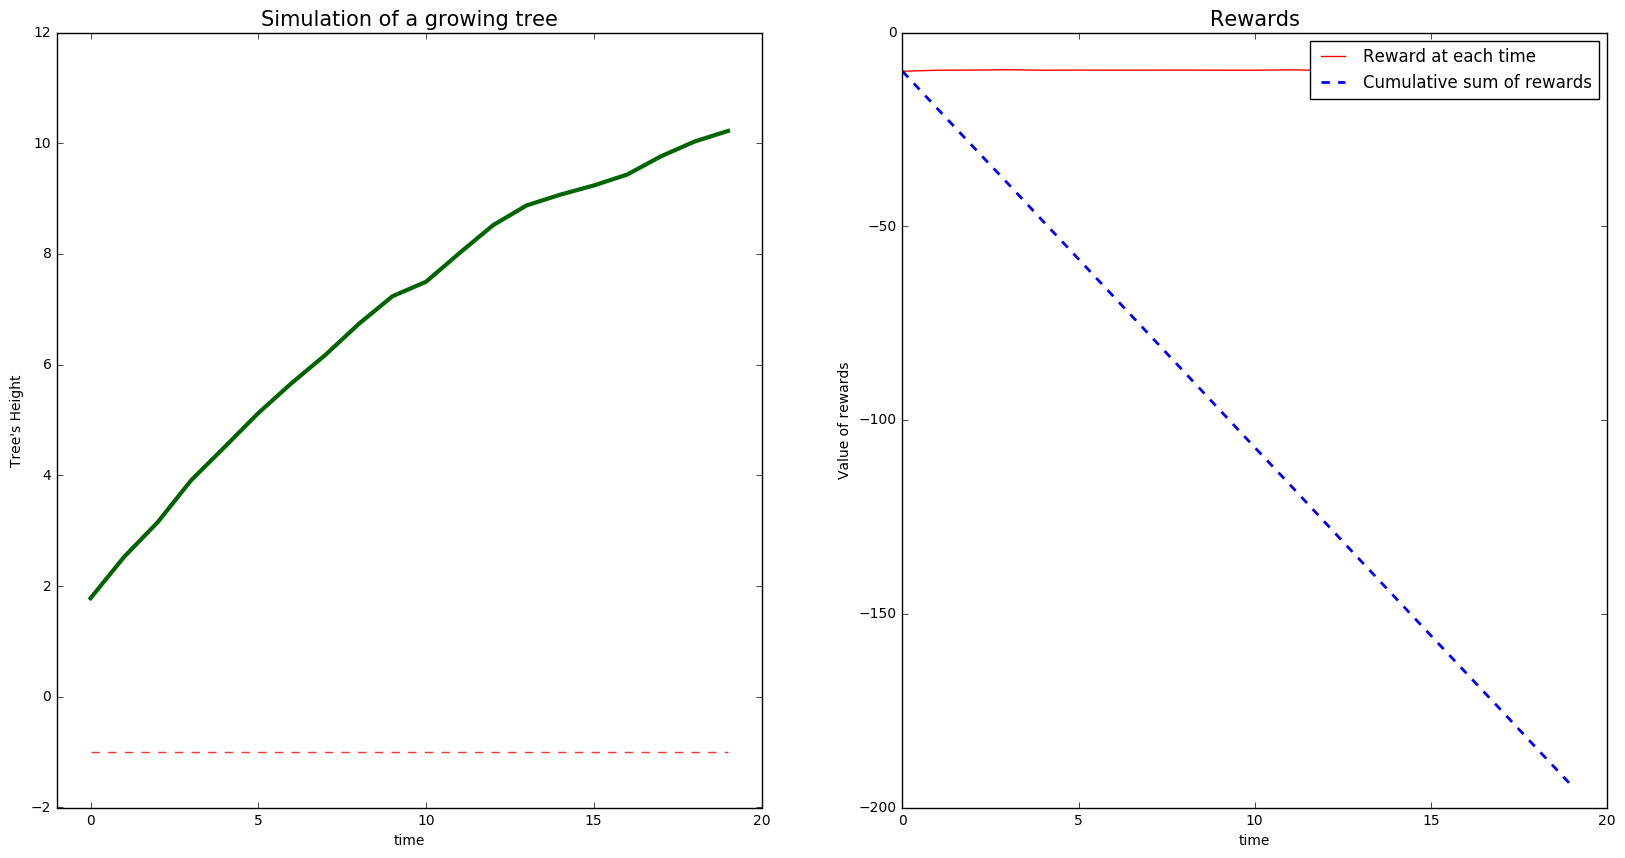

In [97]:
t=Tree(initSize=1,H=50)
arbA=ArbitraryAgent(cut=25)
arbA.plot_policy(nIter=20,nbRuns=1000,tree=t)

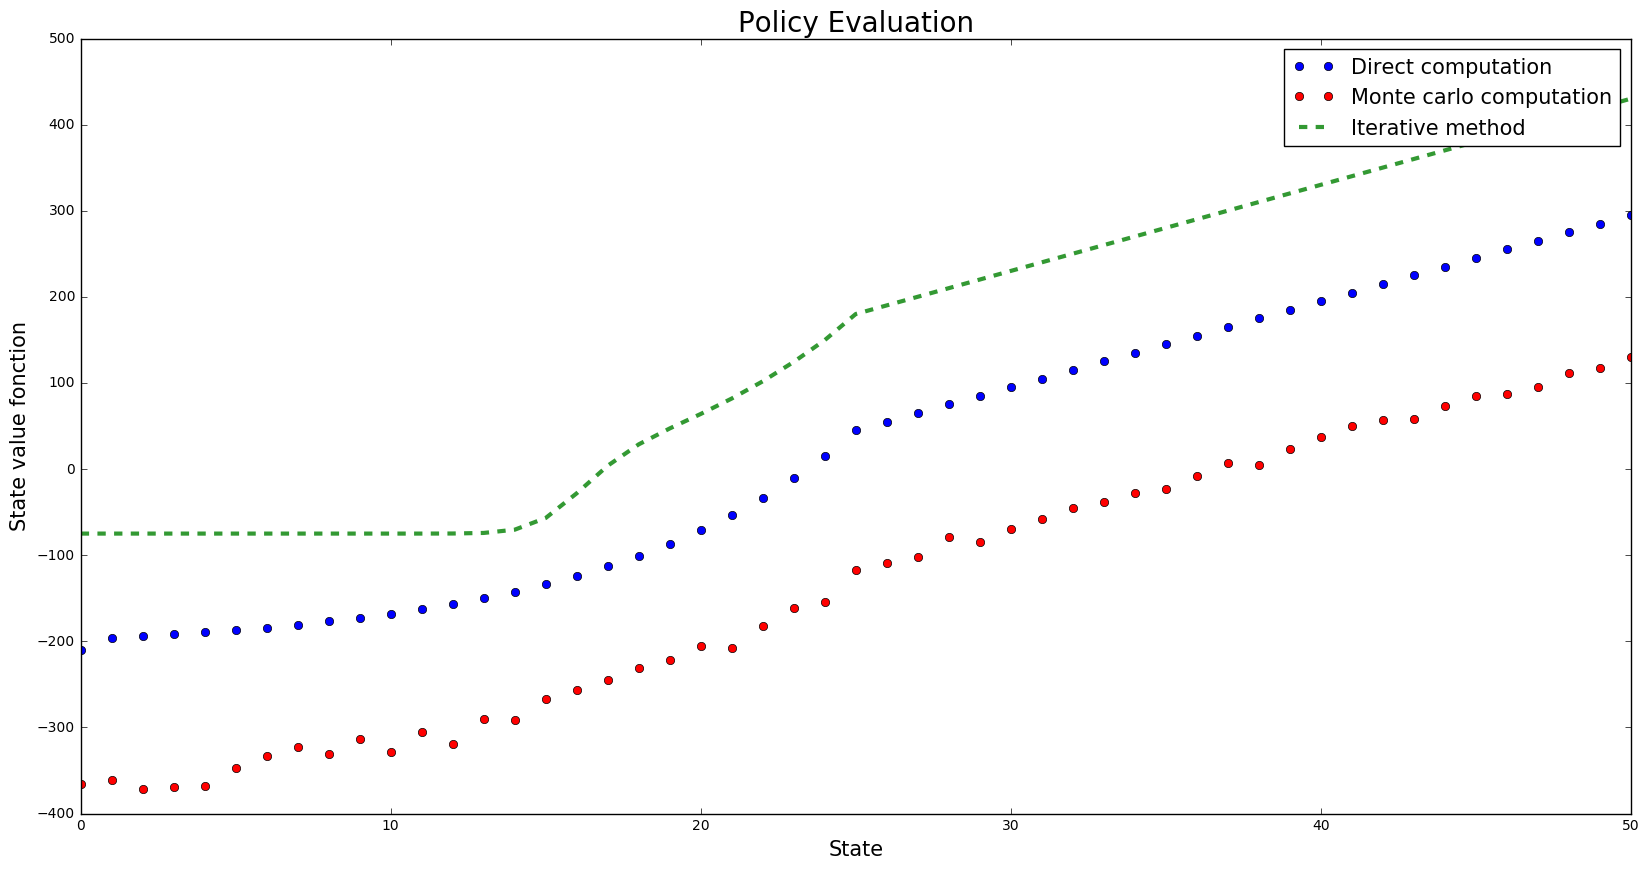

In [99]:
Vdirect=arbA.ev_policy_direct_computation(t)
Vmonte=arbA.ev_policy_motecarlo(t,50,400)
Vinte=arbA.ev_policy_iterative_computation(t,10)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.plot(Vmonte,'ro')
plt.plot(Vinte,'g--',lw=3,alpha=0.8)
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation','Monte carlo computation','Iterative method'],fontsize=15)
plt.show()

### Stupid Agent 

On fait un agent qui ne coupe jamais

In [86]:
class StupidAgent(Agent,ComputeMatrix):
    
    def __init__(self,cut=10):
        Agent.__init__(self)
        ComputeMatrix.__init__(self)
        self.cut=cut
     
    # Doit implémenter une policy déterministe
    def policy(self,x):
         return 0
        
    def simul_policy(self,nIter,tree,nbRuns=1):
        rewards=np.zeros((nIter,nbRuns))
        treeSizes=np.zeros((nIter,nbRuns))

        for run in range(nbRuns):
            t=Tree(initSize=tree.initSize
            ,costOfMaintenance=tree.costOfMaintenance
            ,costOfPlanting=tree.costOfPlanting
            ,H=tree.Hmax
            ,valueUnitOfWood=tree.valueUnitOfWood)
            actions=[]
            for i in range(nIter):
                
                a=self.policy(t.size)            
                res=t.tree_MDP([a])
                rewards[i,run]=res[0]
                treeSizes[i,run]=res[1]
                actions.append(a)   
                    
        if nbRuns==1:
            return rewards,treeSizes,actions
        else:
            return np.mean(rewards,axis=1),np.mean(treeSizes,axis=1)
        
    def plot_policy(self,nIter,nbRuns,tree):
        rewards,treeSizes=self.simul_policy(nIter=nIter,nbRuns=nbRuns,tree=tree)
        tree.plot_MDP(rewards,treeSizes)
    
    # C'est la fonction qui permet de trouver le P et le R de l'équation de bellman
    def find_P_R(self,tree):
        rewards_dic=tree.get_all_rewards()
        P1,P2=self.computePQ(tree.Hmax+1)
        P=np.zeros((tree.Hmax+1,tree.Hmax+1))
        R=[]
        
        
        for i in [-1]+list(range(1,tree.Hmax+1)): #Ensemble des states
            R.append(rewards_dic[(i,self.policy(i))])
            
            # Cas malade on met à la première ligne
            if i==-1:
                P[0,:]=P2[0,:]
            else:
                if self.policy(i)==0:
                    P[i,:]=P1[i,:]
                if self.policy(i)==1:
                    P[i,:]=P2[i,:]
        return P,R
        
    def bellman_op(self,tree,v):
        P,R=self.find_P_R(tree)
        
        return R+tree.discount*np.dot(P,v)
    
    def ev_policy_iterative_computation(self,tree,nIter):
        V=np.zeros(tree.Hmax+1)+10
        
        for i in range(nIter):
            V=self.bellman_op(tree,V)
        
        return V
        
    def ev_policy_direct_computation(self,tree):
        
        P,R=self.find_P_R(tree)
        
        Pinv=self.inv(P,discount=tree.discount)
        V=np.dot(Pinv,R)
        
        return V
    
    def ev_policy_motecarlo(self,tree,nIter,nbRuns):
        rewards=np.zeros((nIter,nbRuns))
        treeSizes=np.zeros((nIter,nbRuns))
        V=[]
        # On regarde chaque state
        for x in [-1]+list(range(1,tree.Hmax+1)):
            
            rewards_trajectory=[]
            # On fait n trajectoires à partir de ce state
            for run in range(nbRuns):
                
                #On créé un arbre qui commence au state x
                t=Tree(initSize=x
                ,costOfMaintenance=tree.costOfMaintenance
                ,costOfPlanting=tree.costOfPlanting
                ,H=tree.Hmax
                ,valueUnitOfWood=tree.valueUnitOfWood)
            
                # On fait varier le temps
                rewards=[]
                for i in range(nIter):

                    a=self.policy(t.size)            
                    res=t.tree_MDP([a])
                    rewards.append(res[0])
                    
                rewards_trajectory.append(np.sum(rewards))
                
            V.append(np.mean(rewards_trajectory))
    
        return V

### Illustration

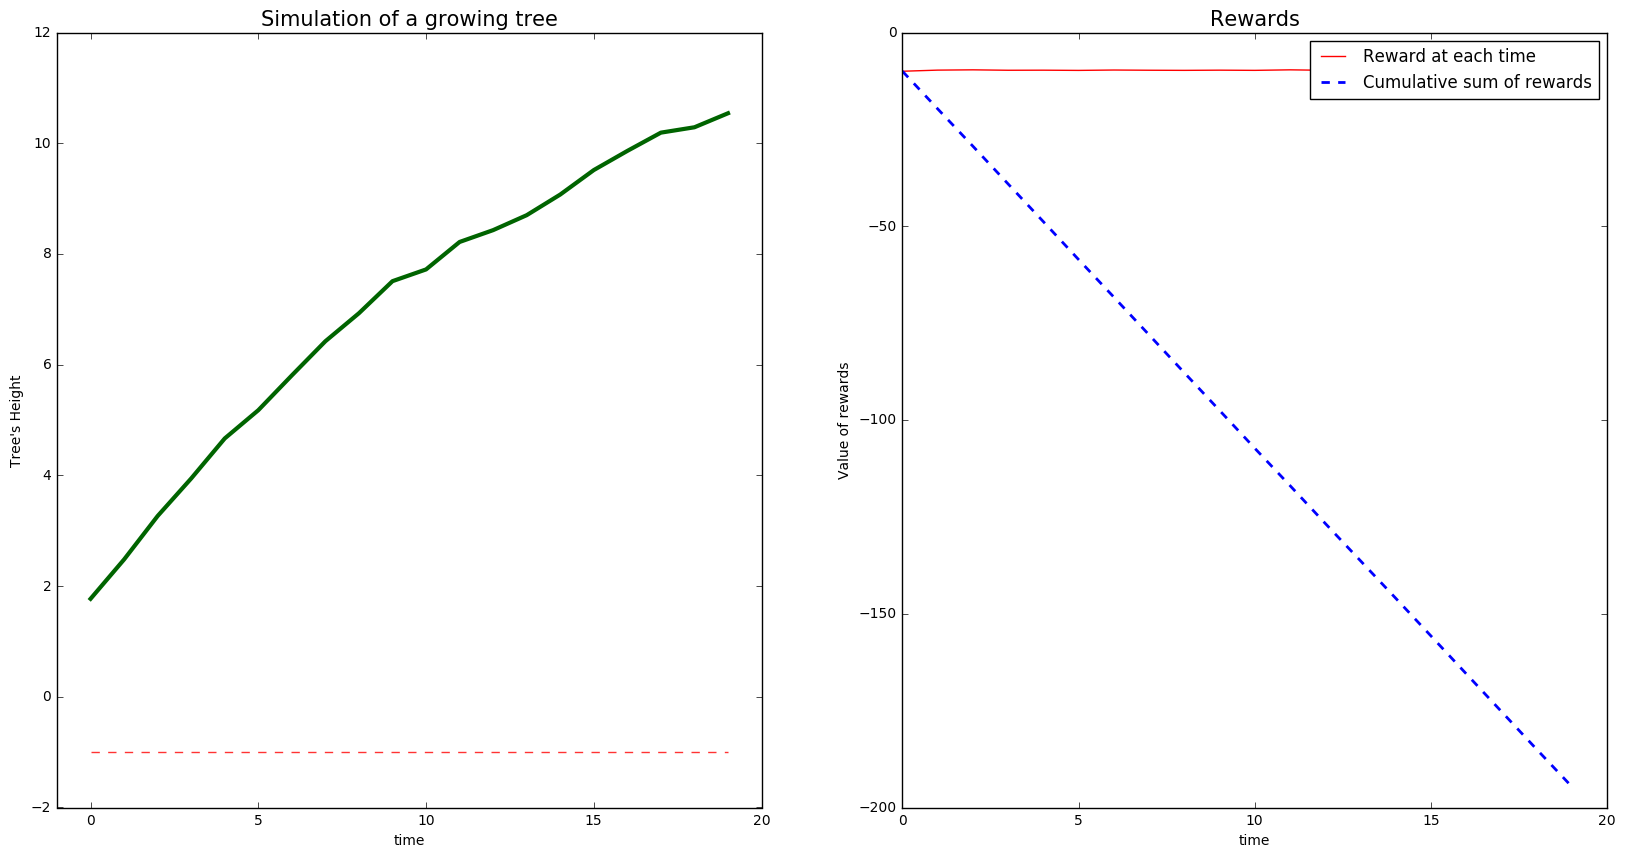

In [88]:
t=Tree(initSize=1,H=100)
stpA=StupidAgent()
stpA.plot_policy(nIter=20,nbRuns=1000,tree=t)

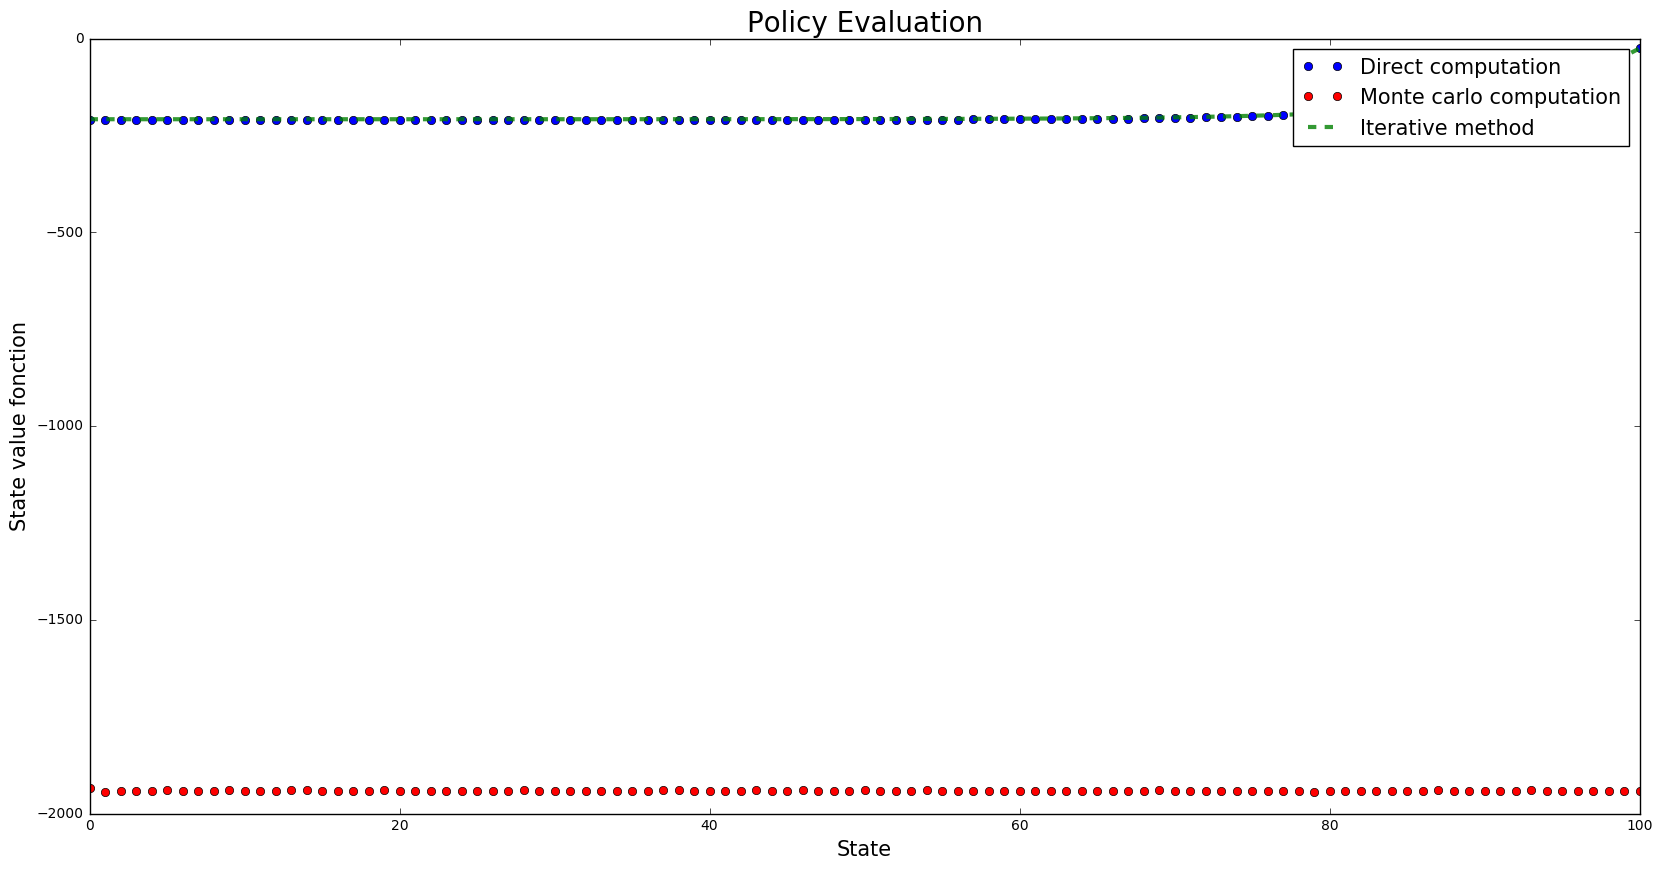

In [92]:
Vdirect=stpA.ev_policy_direct_computation(t)
Vmonte=stpA.ev_policy_motecarlo(t,200,300)
Vinte=stpA.ev_policy_iterative_computation(t,100)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.plot(Vmonte,'ro')
plt.plot(Vinte,'g--',lw=3,alpha=0.8)
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation','Monte carlo computation','Iterative method'],fontsize=15)
plt.show()

Comme l'arbre tombre très rarement malade, et qu'être malade est la seule possibilité d'avoir un reward positif dans ce cas alors monte carlo doit merder mais je sais pas trop...

In [5]:
class AbsurdAgent(Agent):
    
    def __init__(self):
        Agent.__init__(self)
    
    def simul_policy(self,nIter,tree,nbRuns=1):
        rewards=np.zeros((nIter,nbRuns))
        treeSizes=np.zeros((nIter,nbRuns))

        for run in range(nbRuns):
            t=Tree(initSize=tree.initSize
            ,costOfMaintenance=tree.costOfMaintenance
            ,costOfPlanting=tree.costOfPlanting
            ,H=tree.Hmax
            ,valueUnitOfWood=tree.valueUnitOfWood)
            
            actions=list(np.random.randint(2,size=nIter))
            rewards[:,run],treeSizes[:,run]=t.tree_MDP(actions)
         
        if nbRuns==1:
            return rewards,treeSizes,actions
        else:
            return np.mean(rewards,axis=1),np.mean(treeSizes,axis=1)
        
    def plot_policy(self,nIter,nbRuns,tree):
        rewards,treeSizes=self.simul_policy(nIter=nIter,nbRuns=nbRuns,tree=tree)
        tree.plot_MDP(rewards,treeSizes)